## TTAやってみる

In [1]:
import random
import os
from pathlib import Path

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torchvision.transforms import functional as F
from tqdm import tqdm
from PIL import Image

from common.constant import TEST_CSV_PATH, TEST_IMG_ROOT, DST_ROOT_PATH
from common.rle import rle_encoding, rle_decode
from models.mask_rcnn.mask_rcnn_model import get_model
from models.mask_rcnn.mask_rcnn_dataset import SemiTestDataset

In [2]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


# 垂直方向への反転
class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

# 水平方向への反転
class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

# 正規化
class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target
    

def get_transform(train, normalize=False):
    transforms = [ToTensor()]
    if normalize:
        transforms.append(Normalize())

    # オーグメンテーション
    if train:
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))

    return Compose(transforms)

In [3]:
BASE_LINE_MODEL_WEIGHT_PATH = '../../dst/pytorch_model-e5.bin'

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# マスクを残す閾値
MASK_THRESHOLD = 0.5

MIN_SCORE = 0.60

# 保存先
DST_DIR = Path(DST_ROOT_PATH) / '01_mask_rcnn-20230416_tta'
DST_DIR.mkdir(parents=True, exist_ok=True)

In [48]:
horizontal_flip = A.HorizontalFlip(always_apply=True)
vertical_flip = A.VerticalFlip(always_apply=True)


def get_tta_result_for_a_img(model, img, aug_and_deaug_list=[(None, None), (horizontal_flip, horizontal_flip), (vertical_flip, vertical_flip)]):
    result = {'masks': [], 'scores': []}
    for aug, deaug in aug_and_deaug_list:
        tmp_result = get_transformed_masks_and_scores(model, img, aug, deaug)
        result['masks'].append(tmp_result['masks'])
        result['scores'].append(tmp_result['scores'])
    return {k: torch.concat(v) for k, v in result.items()}


def get_transformed_masks_and_scores(model, img, aug_trans, deaug_trans):
    if aug_trans:
        img = img.cpu().numpy().transpose(1, 2, 0)
        img = aug_trans(image=img)['image']
        img, _ = ToTensor()(img, None)
        img = img.to(DEVICE)
    with torch.no_grad():
        result = model([img])[0]
    result = {k: v.to('cpu') for k, v in result.items()}
    new_result = {'masks': result['masks'], 'scores': result['scores']}
    if deaug_trans:
        new_masks = []
        for mask in result['masks']:
            trans_mask = deaug_trans(image=mask[0].cpu().numpy())['image'][None, None, ...]
            new_masks.append(torch.tensor(trans_mask))
        new_masks = torch.concat(new_masks)
        new_result['masks'] = new_masks
    return new_result


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

In [51]:
model = get_model()
model.to(DEVICE)
model.load_state_dict(torch.load(BASE_LINE_MODEL_WEIGHT_PATH))
# modelをevalモードに
model.eval()

test_df = pd.read_csv(TEST_CSV_PATH)
test_ds = SemiTestDataset(TEST_IMG_ROOT, test_df, transforms=get_transform(train=False), resize=True)

submission = []
for sample in tqdm(test_ds, total = test_ds.__len__()):
    img = sample['image']
    image_id = sample['image_id']
    origin_height = sample['height']
    origin_width = sample['width']
    resize = sample['resize']

    result = get_tta_result_for_a_img(model, img.to(DEVICE))
    
    previous_masks = []
    for i, mask in enumerate(result["masks"]):

        # スコアが低いものを除去
        score = result["scores"][i].cpu().item()
        if score < MIN_SCORE:
            continue
        
        mask = mask.cpu().numpy()
        
        if resize:
            mask = cv2.resize(mask[0], dsize = (origin_width, origin_height))
            mask = mask[np.newaxis, :, :]
        
        # 閾値処理
        binary_mask = mask > MASK_THRESHOLD
        if binary_mask.sum() == 0:
            continue
        binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
        previous_masks.append(binary_mask)
        rle = rle_encoding(binary_mask)
        submission.append((image_id, rle))

    # 予測結果がない時は空にしておく
    all_images_ids = [image_id for image_id, rle in submission]
    if image_id not in all_images_ids:
        submission.append((image_id, ""))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [2:11:02<00:00, 280.82s/it]


In [56]:
df_sub = pd.DataFrame(submission, columns=['image', 'predicted'])
df_sub.to_csv(DST_DIR / 'submission.csv', index=False)

## findContoursで補正

In [5]:
test_df = pd.read_csv(TEST_CSV_PATH)
df_sub = pd.read_csv(DST_DIR / 'submission.csv', usecols=['image', 'predicted'])
df_sub.dropna(inplace=True)
group_pred_df = pd.DataFrame(df_sub.groupby("image")["predicted"].apply(list).apply(' '.join))
group_merged_df = pd.merge(group_pred_df, test_df, on='image')
group_merged_df.head()

,image,predicted,height,width
0,pcb_0f_cc_11.png,8648931 246 8653629 312 8658345 336 8663066 34...,3030,4728
1,pcb_11f_cc_11.png,8832501 201 8836888 250 8841291 274 8845689 30...,3155,4420
2,pcb_12f_cc_11.png,12102840 17 12107264 88 12111688 111 12116115 ...,3671,4429
3,pcb_14f_cc_11.png,5051374 18 5058760 34 5058902 74 5066321 76 50...,1957,7566
4,pcb_15f_cc_11.png,8792879 199 8793189 76 8798345 438 8803846 449...,3783,5504


In [4]:
result_df = []
for _, row in tqdm(group_merged_df.iterrows(), total=len(group_merged_df)):
    rle = row['predicted']
    height = row["height"]
    width = row["width"]
    img_name = row['image']
    decoded_img = rle_decode(rle, (height, width), color=1)
    counters, _ = cv2.findContours(decoded_img.astype(np.uint8), mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_NONE, )
    for counter in counters:
        draw_img = np.zeros(decoded_img.shape)
        draw_img = cv2.drawContours(draw_img, [counter], contourIdx=0, color=(1, 1, 1), thickness=-1)
        encoded =  rle_encoding(draw_img)
        result_df.append({'image': img_name, 'predicted': encoded})
result_df = pd.DataFrame(result_df)

100%|███████████████████████████████████████████| 28/28 [02:15<00:00,  4.83s/it]


In [6]:
submissin_df = []
for _, row in test_df.iterrows():
    submissin_df.append(
        result_df[result_df['image'] == row['image']]
    )
submissin_df = pd.concat(submissin_df).reset_index(drop=True)
submissin_df = submissin_df[submissin_df['predicted'] != ''].reset_index(drop=True)
submissin_df.to_csv(DST_DIR / 'fixed_by_opencv_find_contours.csv', index=False)

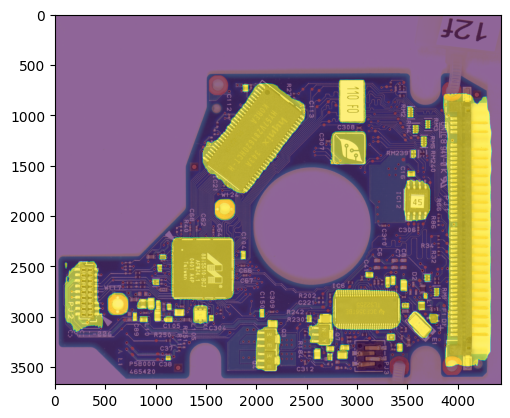

In [10]:
submissin_df = pd.read_csv(DST_DIR / 'fixed_by_opencv_find_contours.csv')
group_pred_df = pd.DataFrame(submissin_df.groupby("image")["predicted"].apply(list).apply(' '.join))
group_merged_df = pd.merge(group_pred_df, test_df, on='image')
row = group_merged_df.iloc[2]
img = plt.imread(TEST_IMG_ROOT / row['image'])
decoded_img = rle_decode(row['predicted'], (row['height'], row['width']), color=1)
plt.imshow(img)
plt.imshow(decoded_img, alpha=0.6)
plt.show()